In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
path = os.environ.get("store_data")
store = pd.HDFStore(path=path)

In [3]:
df = store["Womens Clothing E-Commerce Reviews"];df.head()

,Clothing ID,Age,Title,Review Text,Rating,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,General,Tops,Blouses


In [4]:
df.columns = list(map(lambda x: x.lower(), df.columns))
df.columns  = list(map(lambda x: x.replace(" ", "_"), df.columns))

In [5]:
df.head()

,clothing_id,age,title,review_text,rating,division_name,department_name,class_name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,General,Tops,Blouses


In [6]:
df.dtypes.to_frame(name = "dtypes").T

,clothing_id,age,title,review_text,rating,division_name,department_name,class_name
dtypes,int64,int64,object,object,int64,object,object,object


In [7]:
df.isnull().sum().to_frame(name = "total_nulls").T

,clothing_id,age,title,review_text,rating,division_name,department_name,class_name
total_nulls,0,0,3810,845,0,14,14,14


In [8]:
df2 = df.dropna(axis = 0, subset=["review_text"], ignore_index=True)

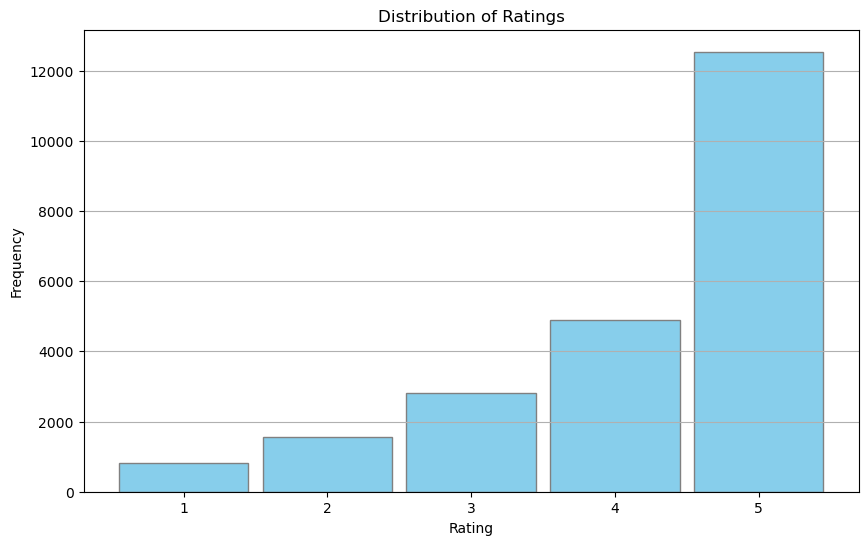

,count,mean,std,min,50%,max
statistic,"22,641,00","4,18","1,12","1,00","5,00","5,00"


In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df2["rating"], bins=range(1, 7), align='left', rwidth=0.9, color='skyblue', edgecolor='gray')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks(range(1, 6))
plt.grid(axis='y')
plt.show()
df2["rating"].describe(percentiles=[]).to_frame(name = "statistic").T.style.format(thousands = ",", decimal = ",", precision = 2)

In [212]:
df2.loc[: ,"review_text_len"] = df2.loc[:, "review_text"].str.len()

In [11]:
from scipy.stats import pearsonr
correlation = pearsonr(df2["rating"], df2["review_text_len"])
print(f"the correlation beetween rating and review length is: {correlation[0]:.2f}\nThe longer the review, the more likely it is to be negatively rated.\nBut  since the correlation value is very close to zero, we can also comment that there is no significant relationship between the two variables.")

the correlation beetween rating and review length is: -0.06
The longer the review, the more likely it is to be negatively rated.
But  since the correlation value is very close to zero, we can also comment that there is no significant relationship between the two variables.


In [12]:
import re
pattern_dict = {
      "positive_pattern":re.compile(r'\b(great|good|excellent|amazing|love|best|awesome|fantastic|wonderful|brilliant|incredible|outstanding|superb|marvelous|impressive)\b'),               "negative_pattern":re.compile(r'\b(terrible|awful|horrible|poor|worst|bad|dreadful|hate|dislike|despise|detest|loathe|disappointing|unacceptable|annoying|frustrating|pathetic|failure|ruin|disaster|nightmare)\b'),
    "question": re.compile(r'\b(who|what|where|when|why|how|which|is it|are they|does anyone|could you|would it|might I|can we|do you think)\b'),
    "exclamation": re.compile(r'\b(wow|oh my|amazing!|incredible!|no way!|unbelievable!|fantastic!|whoa!|awesome!|ouch!|yay!)\b'),
    "capital_words": re.compile(r'\b([A-Z]{2,})\b')
}

pattern_count = dict.fromkeys(pattern_dict, 0)
for item in df2["review_text"]:
    for key, value in pattern_dict.items():
        if re.search(value, item):
            pattern_count[key] += 1
pattern_count

{'positive_pattern': 11929,
 'negative_pattern': 978,
 'question': 7072,
 'exclamation': 104,
 'capital_words': 0}

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import string

text cleaning and normalization

In [15]:
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans(" ", " ", string.punctuation))
    return text

df3 = df2.copy()
df3.loc[:, "review_text"] = df3.loc[:, "review_text"].apply(clean_text)

data split

In [64]:
x = df3.loc[:, "review_text"]
y = df3.loc[:, "rating"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state = 365)

In [66]:
print(f" x_train: {x_train.shape[0]}; x_test: {x_test.shape[0]}\n y_train {y_train.shape[0]}; y_test: {y_test.shape[0]}")

 x_train: 18112; x_test: 4529
 y_train 18112; y_test: 4529


In [68]:
vectorizer = TfidfVectorizer(stop_words="english")
model = MultinomialNB()
text_pipe = make_pipeline(vectorizer, model)
text_pipe.fit(x_train, y_train)
y_pred =  text_pipe.predict(x_test)
report = classification_report(y_test, y_pred, zero_division=np.nan, output_dict=True)
confusion_mtx = confusion_matrix(y_test, y_pred)

In [108]:
pd.DataFrame(confusion_mtx, columns = [1, 2, 3, 4, 5], index = [1, 2, 3, 4, 5])

,1,2,3,4,5
1,0,0,4,3,156
2,0,0,3,1,315
3,0,0,2,4,523
4,0,0,0,3,964
5,0,0,0,1,2550


In [221]:
pd.DataFrame(report)

,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,NaN,NaN,0.222222,0.250000,0.565661,0.564142,0.345961,0.445344
recall,0.0,0.0,0.003781,0.003102,0.999608,0.564142,0.201298,0.564142
f1-score,0.0,0.0,0.007435,0.006129,0.722482,0.564142,0.147209,0.409121
support,163.0,319.0,529.000000,967.000000,2551.000000,0.564142,4529.000000,4529.000000


In [116]:
df3.rating.value_counts()

rating
5    12540
4     4908
3     2823
2     1549
1      821
Name: count, dtype: int64

sınıf dağılımları dengesiz olduğundan upsampling yapılarak dengeli hale getirilecektir.

In [138]:
from sklearn.utils import resample

df_majority = df3[df3.rating == 5]
df_minority = df3[df3.rating < 5]


df_minority_upsample = resample(df_minority, replace=True, n_samples=len(df_majority), random_state = 365)

df_upsample = pd.concat([df_majority, df_minority_upsample], ignore_index = True)

In [219]:
df_upsample["rating"].value_counts()

rating
5    12540
4     5975
3     3520
2     1948
1     1097
Name: count, dtype: int64

In [ ]:
x_upsample = df_upsample["review_text"]
y_upsample = df_upsample["rating"]

x_upsample_train, x_upsample_test, y_upsample_train, y_upsample_test = train_test_split(x_upsample, y_upsample, test_size=0.20, random_state=365)
text_pipe_upsample = make_pipeline(vectorizer, model)
text_pipe_upsample.fit(x_upsample_train, y_upsample_train )
y_pred_upsample = text_pipe_upsample.predict(x_upsample_test)
report_upsample = classification_report(y_upsample_test, y_pred_upsample, output_dict=True)
confusion_mtx_upsample = confusion_matrix(y_upsample_test, y_pred_upsample)

In [170]:
pd.DataFrame(confusion_mtx_upsample, columns = [1, 2, 3, 4, 5], index = [1, 2, 3, 4, 5])

,1,2,3,4,5
1,4,0,17,23,171
2,0,3,16,42,348
3,0,0,48,49,635
4,0,0,0,113,1105
5,0,0,0,6,2436


In [166]:
pd.DataFrame(report_upsample)

,1,2,3,4,5,accuracy,macro avg,weighted avg
precision,1.000000,1.000000,0.592593,0.484979,0.518850,0.519139,0.719284,0.581243
recall,0.018605,0.007335,0.065574,0.092775,0.997543,0.519139,0.236366,0.519139
f1-score,0.036530,0.014563,0.118081,0.155755,0.682640,0.519139,0.201514,0.390144
support,215.000000,409.000000,732.000000,1218.000000,2442.000000,0.519139,5016.000000,5016.000000


tahmin gücü biraz daha artmış durumda. ancak istenilen düzeyde değil. sınıfları binary olacak şekilde yeniden oluşturarak tahmin gücünü daha fazla arttırılabilir

In [184]:
def binary(rating):
    if rating >=4:
        return "good"
    else:
        return "bad"

binary_rating = df3.copy()
binary_rating["rating"] =  binary_rating["rating"].apply(binary)


x_binary = binary_rating["review_text"]
y_binary = binary_rating["rating"]

x_train_binary, x_test_binary, y_train_binary, y_test_binary = train_test_split(x_binary, y_binary, test_size=0.20, random_state=365)
text_pipe_binary = make_pipeline(vectorizer, model)
text_pipe_binary.fit(x_train_binary, y_train_binary)
y_pred_binary = text_pipe_binary.predict(x_test_binary)

report_binary = classification_report(y_test_binary, y_pred_binary, output_dict=True)
confusion_mtx_binary = confusion_matrix(y_test_binary, y_pred_binary)

In [223]:
pd.DataFrame(report_binary)

,bad,good,accuracy,macro avg,weighted avg
precision,0.984127,0.787506,0.790241,0.885816,0.831397
recall,0.061325,0.999716,0.790241,0.530521,0.790241
f1-score,0.115456,0.881012,0.790241,0.498234,0.710118
support,1011.000000,3518.000000,0.790241,4529.000000,4529.000000


In [186]:
confusion_mtx_binary

array([[  62,  949],
       [   1, 3517]], dtype=int64)

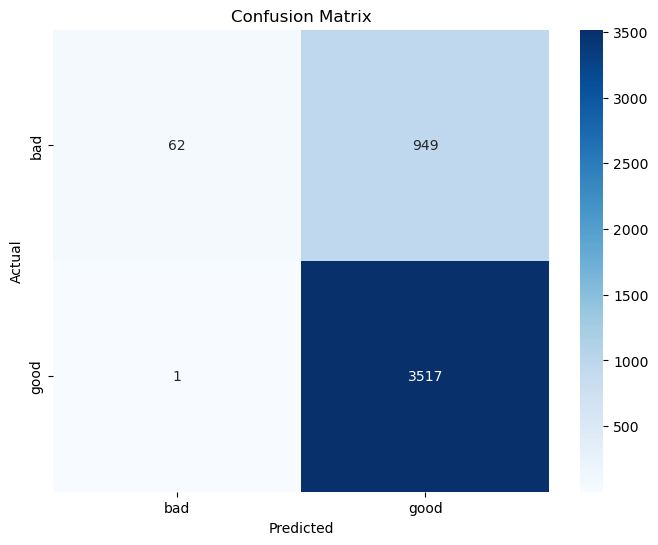

,bad,good,accuracy,macro avg,weighted avg
precision,0.984127,0.787506,0.790241,0.885816,0.831397
recall,0.061325,0.999716,0.790241,0.530521,0.790241
f1-score,0.115456,0.881012,0.790241,0.498234,0.710118
support,1011.000000,3518.000000,0.790241,4529.000000,4529.000000


In [190]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx_binary, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
pd.DataFrame(report_binary)

upsampling işlemini binary dataset için de uygulanması

In [194]:
binary_rating["rating"].value_counts()

rating
good    17448
bad      5193
Name: count, dtype: int64

In [196]:
df_majority_binary = binary_rating[binary_rating.rating == 'good']
df_minority_binary = binary_rating[binary_rating.rating == 'bad']


df_minority_upsampled_binary = resample(df_minority_binary, 
                                        replace=True,     
                                        n_samples=len(df_majority_binary), 
                                        random_state=365) 


df_upsampled_binary = pd.concat([df_majority_binary, df_minority_upsampled_binary])


df_upsampled_binary["rating"].value_counts()


rating
good    17448
bad     17448
Name: count, dtype: int64

In [204]:
x_upsampled_binary = df_upsampled_binary['review_text']
y_upsampled_binary = df_upsampled_binary['rating']


x_train_upsampled_binary, x_test_upsampled_binary, y_train_upsampled_binary, y_test_upsampled_binary = train_test_split(
    x_upsampled_binary, y_upsampled_binary, test_size=0.2, random_state=365)


text_pipe_upsampled_binary = make_pipeline(vectorizer, model)
text_pipe_upsampled_binary.fit(x_train_upsampled_binary, y_train_upsampled_binary)

y_pred_upsampled_binary = text_pipe_upsampled_binary.predict(x_test_upsampled_binary)


report_upsampled_binary = classification_report(y_test_upsampled_binary, y_pred_upsampled_binary, output_dict=True)


confusion_mtx_upsampled_binary = confusion_matrix(y_test_upsampled_binary, y_pred_upsampled_binary)


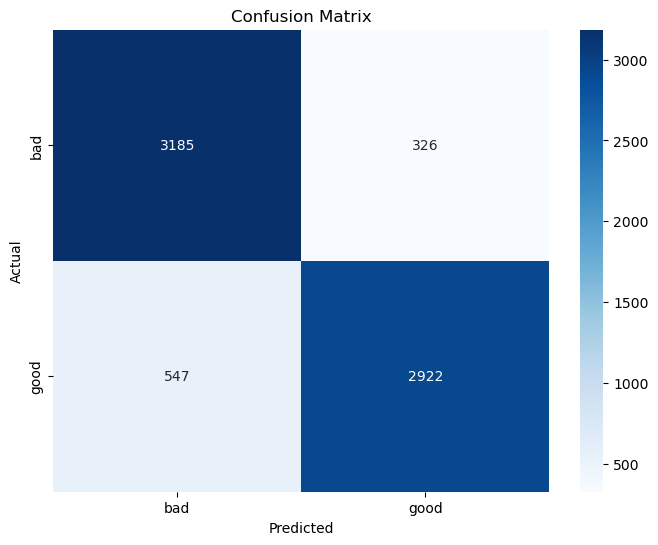

,bad,good,accuracy,macro avg,weighted avg
precision,0.853430,0.899631,0.874928,0.876530,0.876391
recall,0.907149,0.842318,0.874928,0.874733,0.874928
f1-score,0.879470,0.870031,0.874928,0.874751,0.874779
support,3511.000000,3469.000000,0.874928,6980.000000,6980.000000


In [206]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx_upsampled_binary, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
pd.DataFrame(report_upsampled_binary)

f1-score 1 e yaklaştıkça modelin tahmin gücü ve performansı artar.

#### modelin test edilmesi

In [304]:
test_data = pd.read_csv(r"C:\Users\yy\Desktop\test_data.csv")

In [306]:
test_data.columns = list(map(lambda x: x.lower(), test_data.columns))
test_data.columns  = list(map(lambda x: x.replace(" ", "_"), test_data.columns))
test_data2 = test_data.copy()
test_data2 = test_data2.dropna(subset = "review_text", ignore_index=True)
test_data2.loc[:, "review_text"] = test_data2.loc[: ,"review_text"].apply(clean_text)

In [ ]:
test_data2.loc[:, "rating"] = test_data2.loc[:,"rating"].astype(dtype = "int64")
test_data2.loc[:, "rating"] = test_data2.loc[:,"rating"].apply(binary)

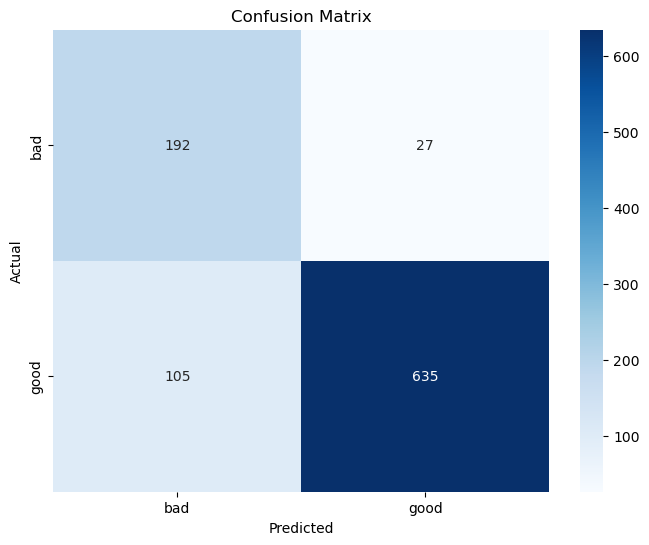

,bad,good,accuracy,macro avg,weighted avg
precision,0.646465,0.959215,0.862357,0.802840,0.887794
recall,0.876712,0.858108,0.862357,0.867410,0.862357
f1-score,0.744186,0.905849,0.862357,0.825017,0.868931
support,219.000000,740.000000,0.862357,959.000000,959.000000


In [324]:
x_test = test_data2["review_text"]
y_test = test_data2["rating"]


y_pred_test = text_pipe_upsampled_binary.predict(x_test)

test_report = classification_report(y_test, y_pred_test, output_dict=True)
confusion_mtx_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
pd.DataFrame(report_upsampled_binary)
pd.DataFrame(test_report)

Model yeni veri setinde iyi bir genel doğruluk oranı (%86.2) yakaladı